# IROP Project File

## Generalisation to Weighted Graph

The following produces illustrations for weighted graphs with the following rule:

Suppose the euclidian distance between two nodes is $d < R$ then the weight between the two nodes is given by $1-\frac{d}{R}$ for $R$ the radius defined in the full set of notes. 

In [24]:
import numpy as np


#Generates N nodes and returns an array of tuples of their position.
def N_node_gen(N):
    node_list = list()
    for _ in range(N):
        node_list.append(np.array((np.random.random(), np.random.random())))
    return node_list

test_nodes = N_node_gen(5)
test_nodes

[array([0.49293655, 0.62777177]),
 array([0.94253801, 0.14970866]),
 array([0.21491643, 0.49225404]),
 array([0.39126367, 0.02156134]),
 array([0.15384761, 0.22971522])]

In [25]:
import numpy as np

#Returns adjacency matrix of the generated graph

def adj_mat_gen(node_list, R):
    N = len(node_list)
    adj_mat = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(node_list[i]-node_list[j])
            if dist < R:
                adj_mat[i, j] = 1 - dist/R
                adj_mat[j, i] = 1 - dist/R
    return adj_mat

test_adj_mat = adj_mat_gen(test_nodes, 0.5)

test_adj_mat

array([[0.        , 0.        , 0.3814202 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.3814202 , 0.        , 0.        , 0.        , 0.46090434],
       [0.        , 0.        , 0.        , 0.        , 0.36851152],
       [0.        , 0.        , 0.46090434, 0.36851152, 0.        ]])

In [26]:
#Produces the matrix W(i)

def W_i_gen(i, adj_mat, gamma):
    i -= 1
    W_i = np.zeros(np.shape(adj_mat), dtype=np.float64)
    N = np.shape(adj_mat)[0]
    for j in range(N):
        if adj_mat[i, j]:
            val = adj_mat[i, j].item()
            W_i[j, j] = 1 - gamma * val
            W_i[j, i] = gamma * val
        else:
            W_i[j, j] = 1
    return W_i

test_W_1 = W_i_gen(1, test_adj_mat, 0.5)

test_W_1

array([[1.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 1.       , 0.       , 0.       , 0.       ],
       [0.1907101, 0.       , 0.8092899, 0.       , 0.       ],
       [0.       , 0.       , 0.       , 1.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 1.       ]])

In [27]:
#A single step of the simulation

def update_step(x, adj_mat, gamma):
    N = len(x)
    i = np.random.randint(N, size=1)
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

test_x = np.random.random(size=5)
update_step(test_x, test_adj_mat, 0.5)

array([0.46823338, 0.96327913, 0.4304415 , 0.80501569, 0.72981842])

In [28]:
import numpy as np

def simulate(x_0, adj_mat, gamma, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

test_x = np.random.random(size=5)
test_simulation = simulate(test_x, test_adj_mat, 0.5, 10)
test_simulation

array([[0.80942615, 0.89470777, 0.11772673, 0.49630727, 0.04167848],
       [0.80942615, 0.89470777, 0.10020124, 0.4125393 , 0.04167848],
       [0.6741698 , 0.89470777, 0.10020124, 0.4125393 , 0.05516518],
       [0.6741698 , 0.89470777, 0.08982259, 0.34669106, 0.05516518],
       [0.6741698 , 0.89470777, 0.2012635 , 0.34669106, 0.05516518],
       [0.6741698 , 0.89470777, 0.29145151, 0.34669106, 0.05516518],
       [0.6741698 , 0.89470777, 0.29145151, 0.34669106, 0.1088805 ],
       [0.60118155, 0.89470777, 0.29145151, 0.34669106, 0.15095439],
       [0.60118155, 0.89470777, 0.35052016, 0.34669106, 0.15095439],
       [0.60118155, 0.89470777, 0.35052016, 0.34669106, 0.18702   ],
       [0.60118155, 0.89470777, 0.31284119, 0.31727074, 0.18702   ]])

In [ ]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gamma = 0.5
sim_num = 1000

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [ ]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))

for _ in range(sim_num):
    x_array += simulate(x_0, adj_mat, gamma, time)

x_array /= sim_num
x_array -= desired_x

plot_vals = np.linalg.norm(x_array, axis=1)

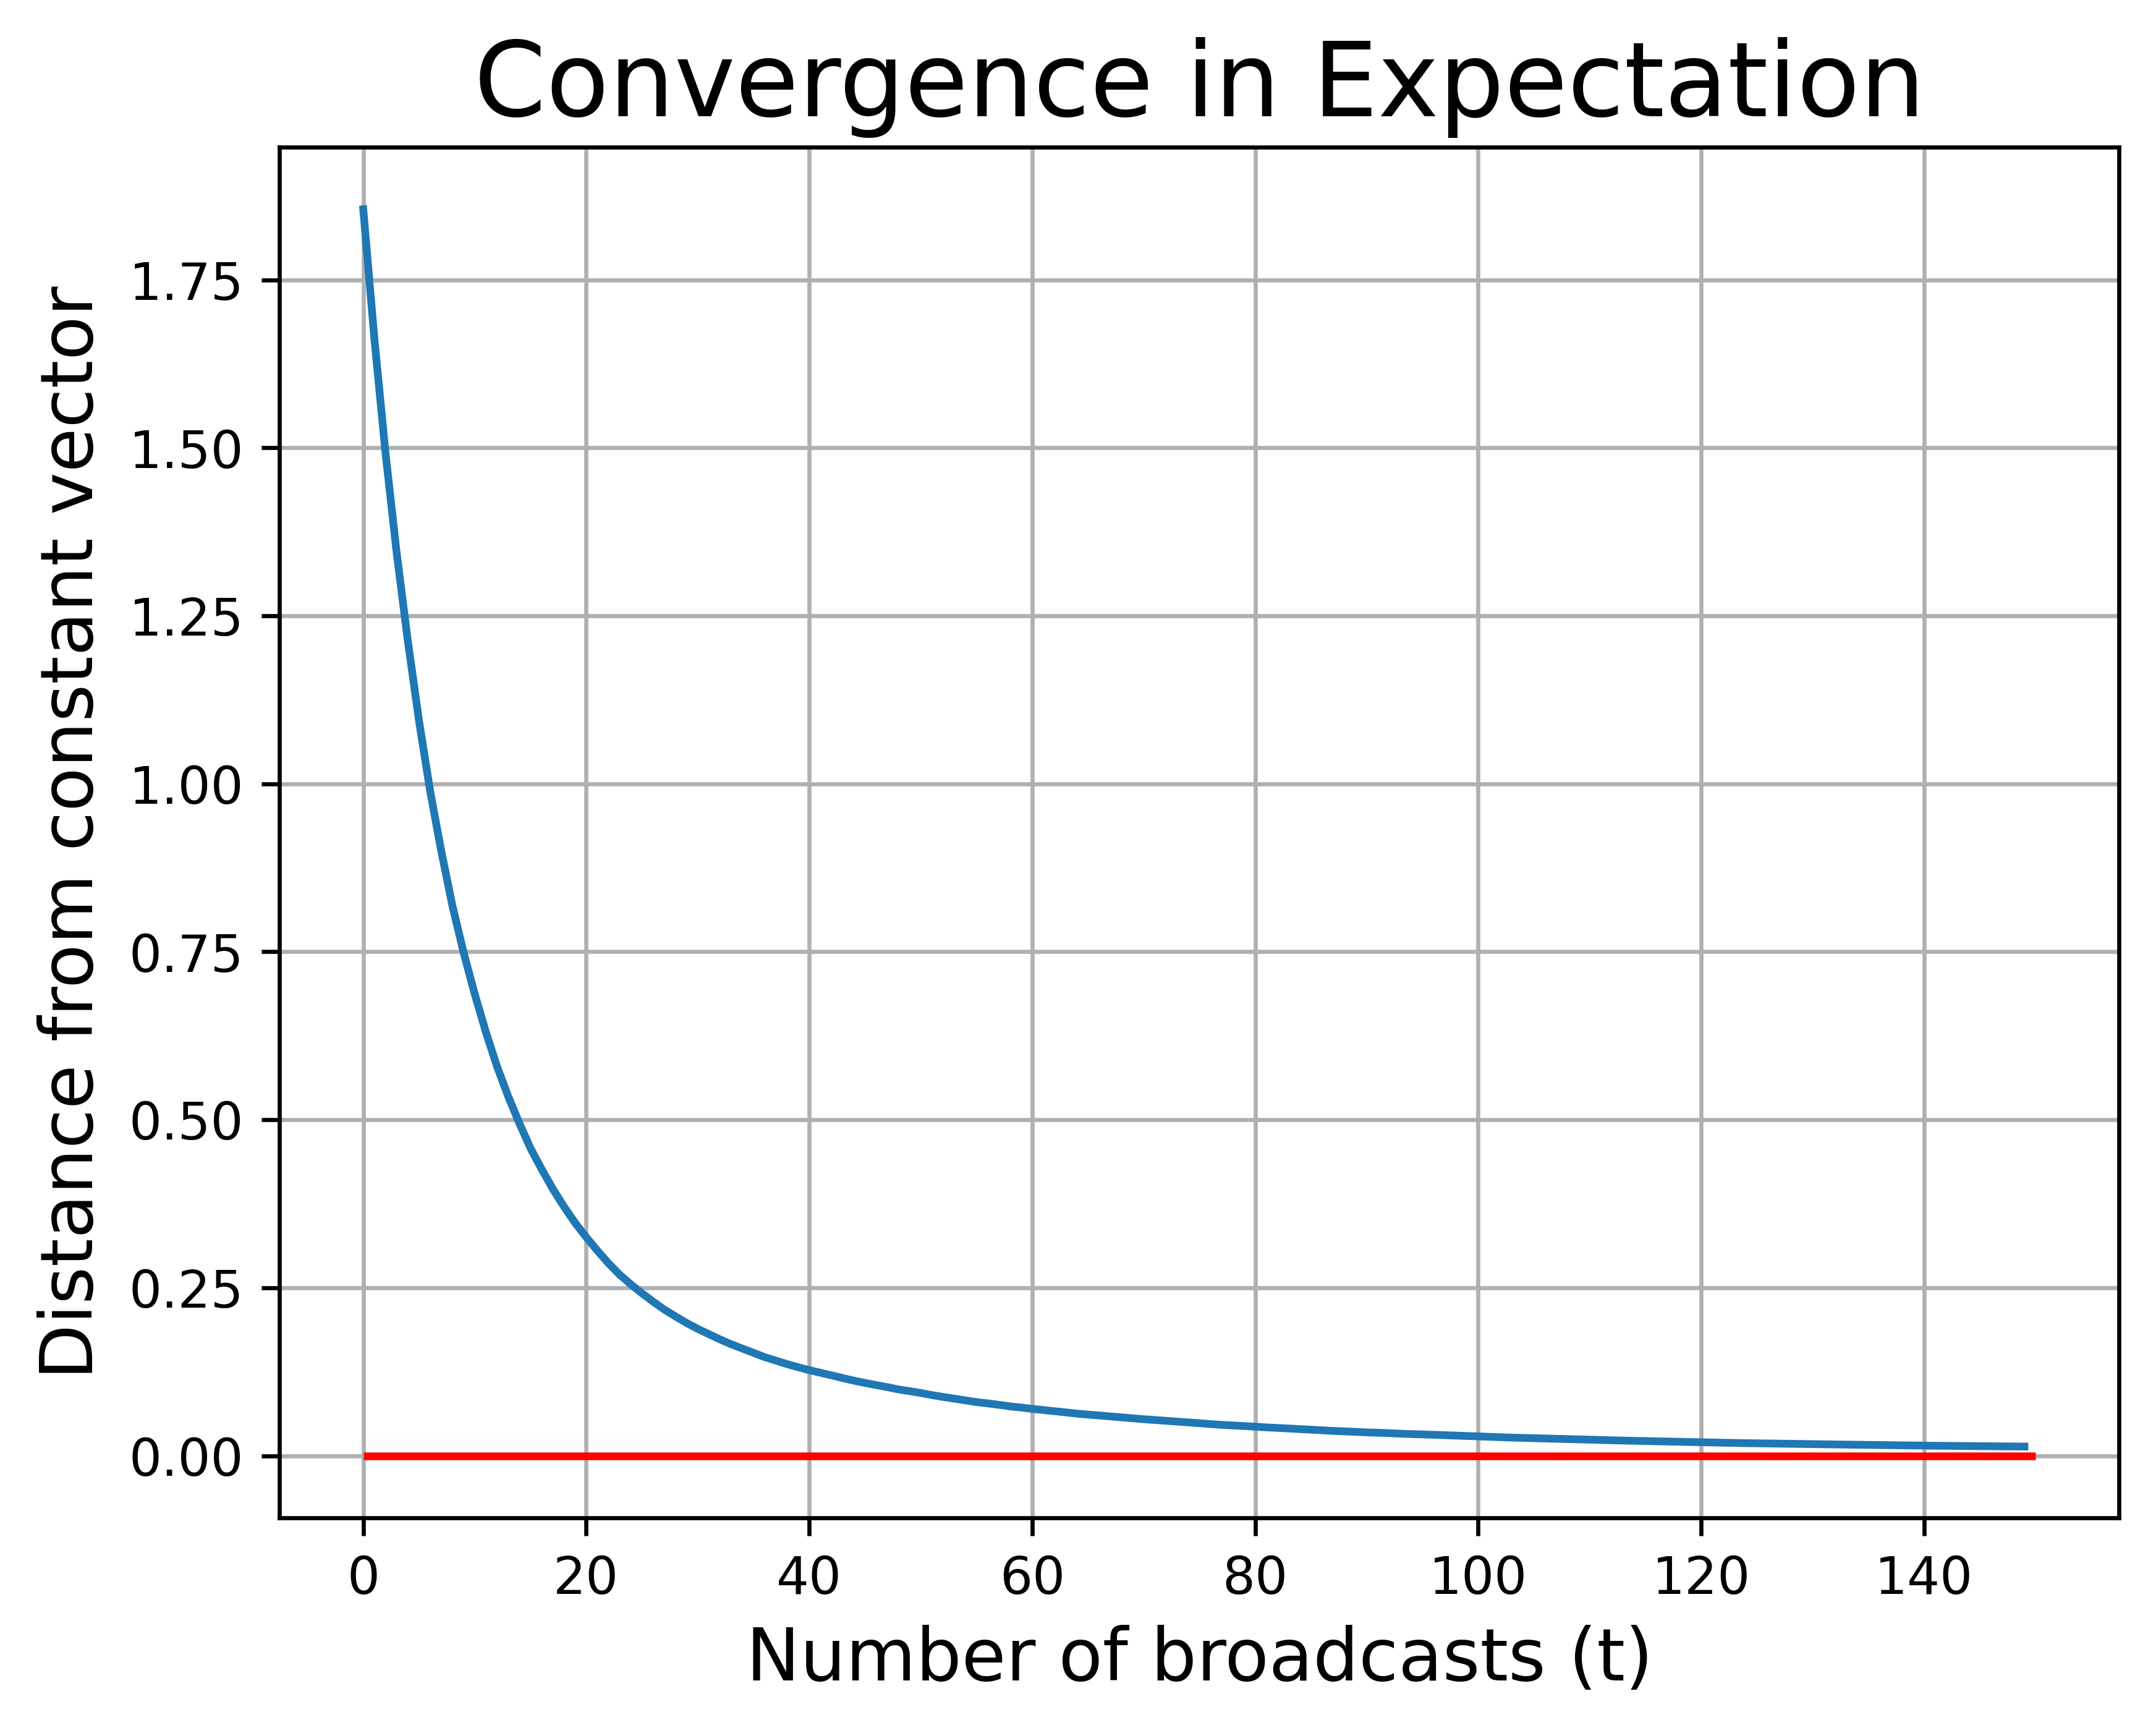

In [52]:
#Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:150], plot_vals[0:150])
ax.hlines(0, 0, 150, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation", fontsize=20)
fig.set_dpi(600)

In [ ]:
#Convergence in second moment data generation

t = time

x_0 = np.random.random(N)
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
t_array = np.array([_ for _ in range(t+1)])
beta_arr = np.zeros((t+1, N), dtype=np.float64)

for _ in range(sim_num):
    output = simulate(x_0, adj_mat, gamma, t)
    for i in range(t+1):
        beta_arr[i] += beta_matrix@output[i]

plot_vals_2 = np.linalg.norm(beta_arr, axis=1)
plot_vals_2 /= sim_num

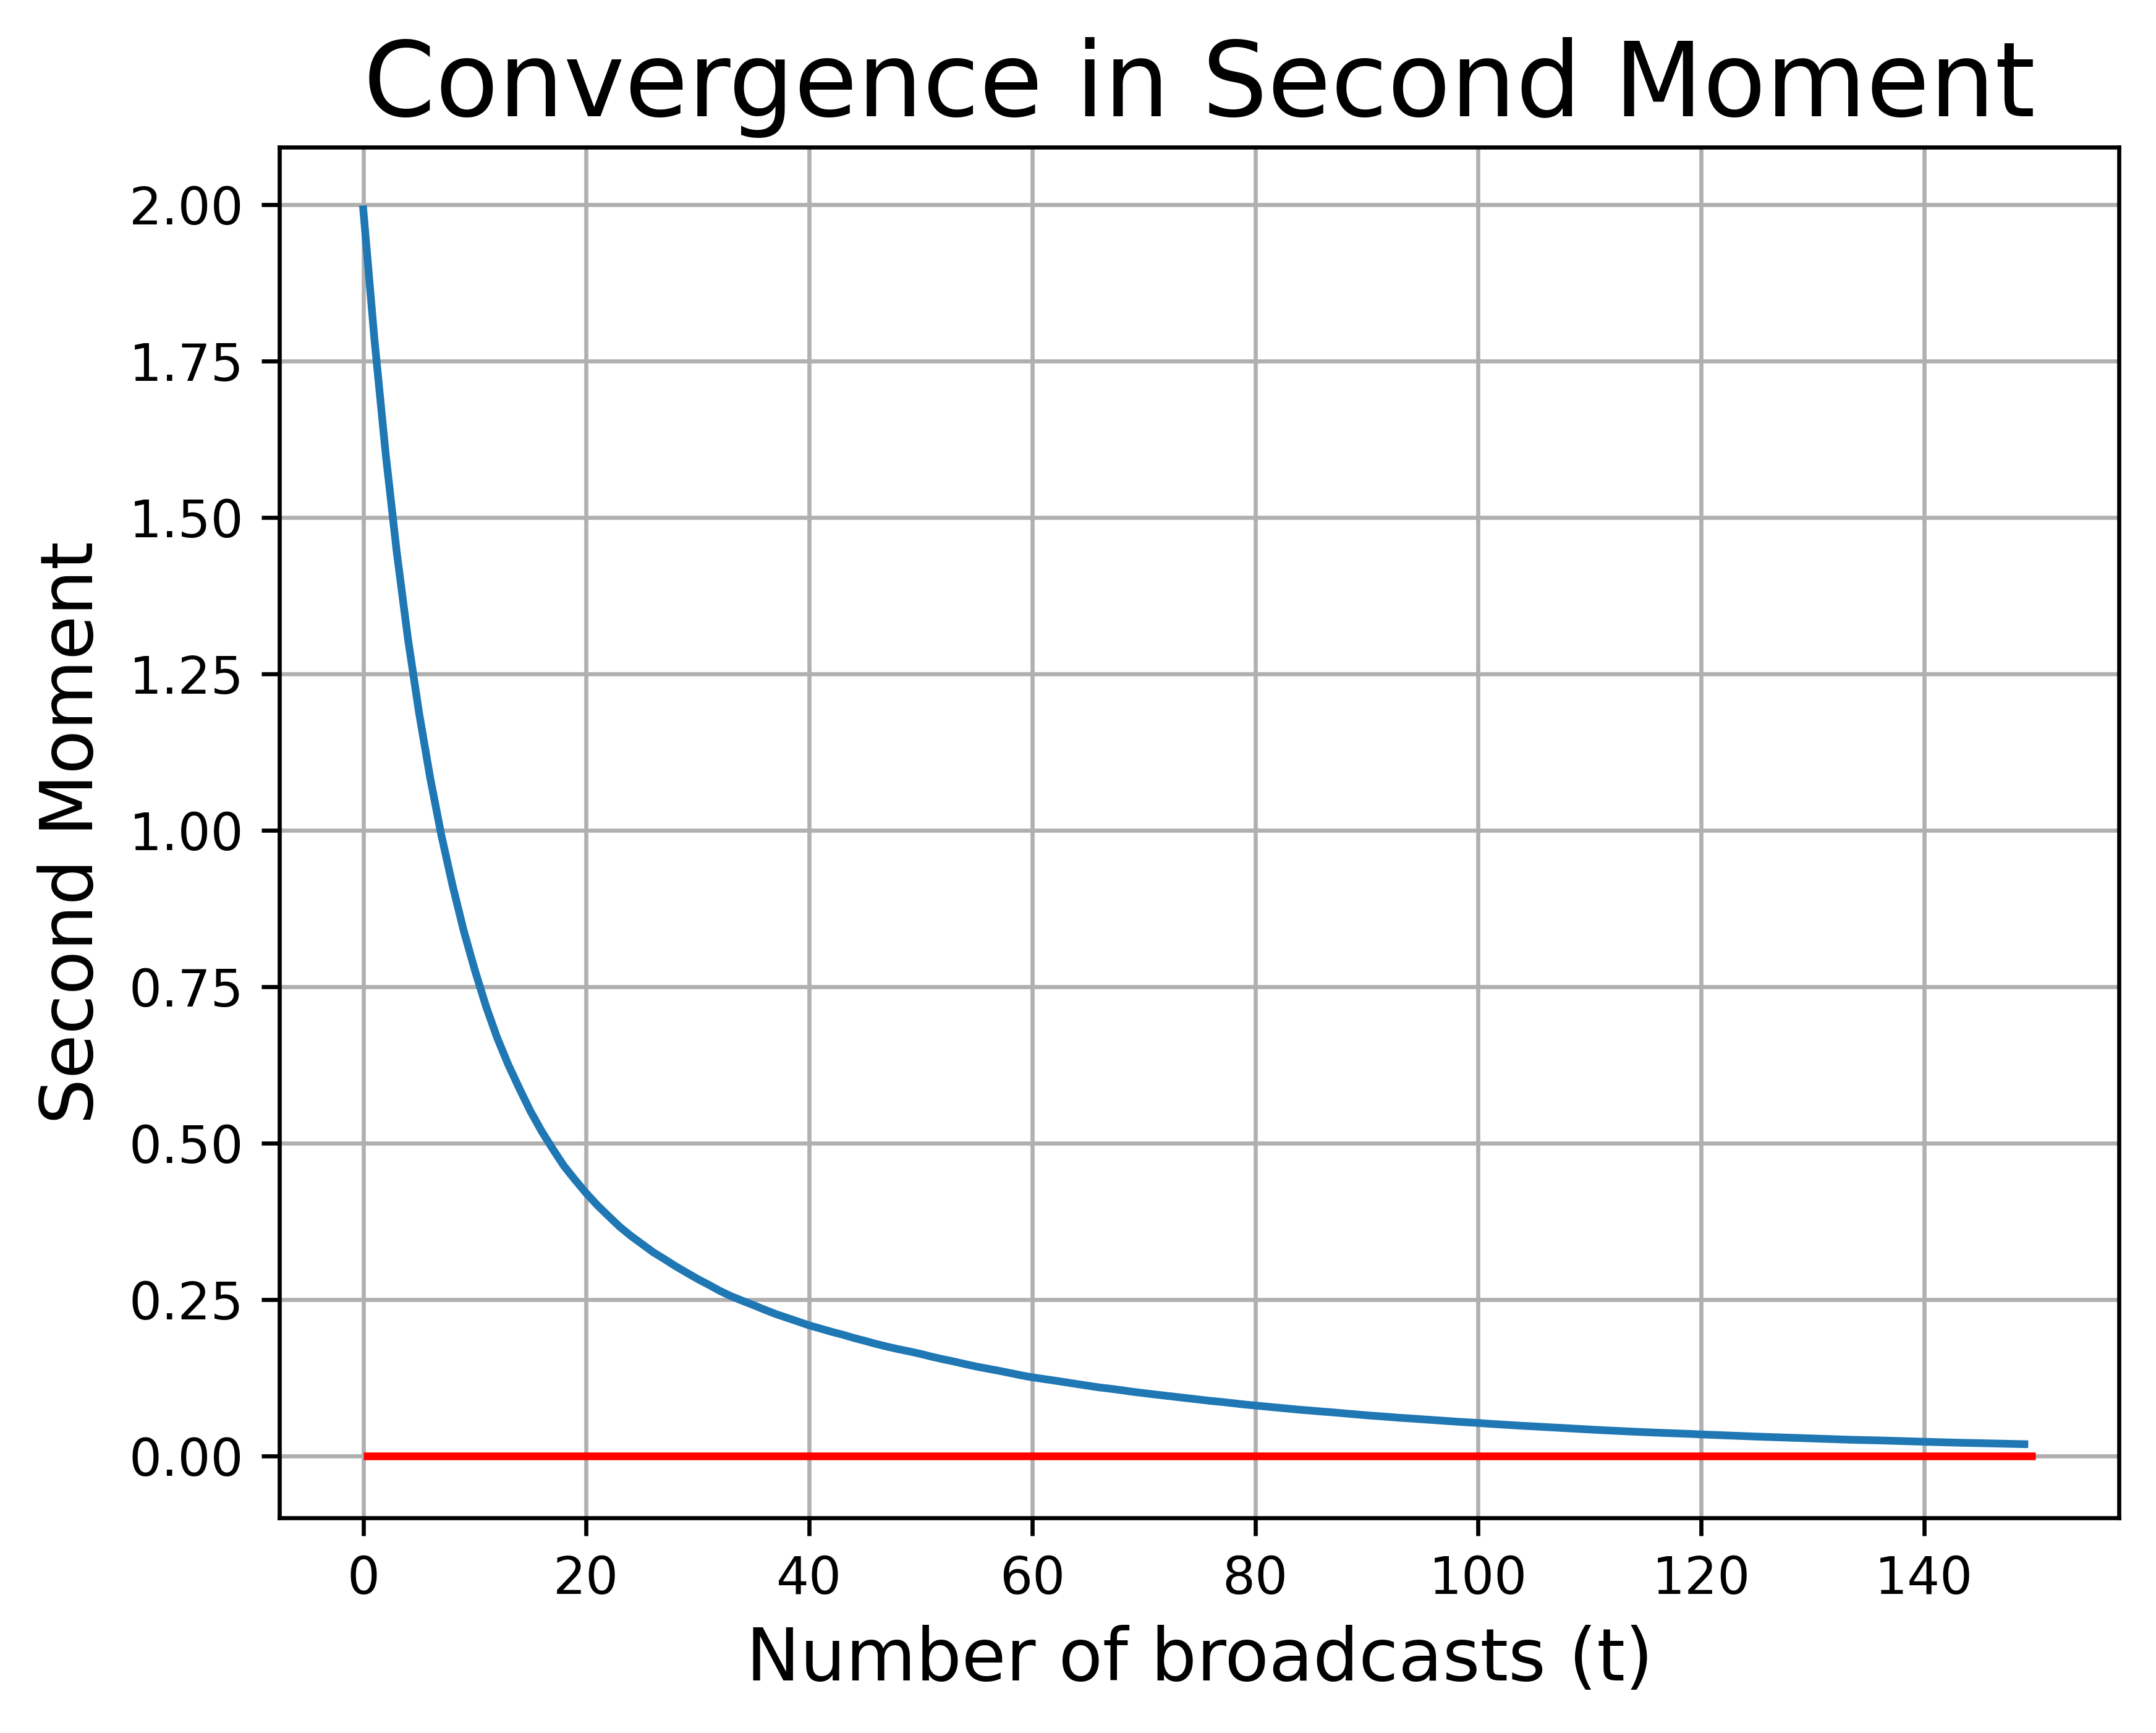

In [54]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:150], plot_vals_2[0:150])
ax.hlines(0, 0, 150, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment", fontsize=20)
fig.set_dpi(600)

## Generalisation to Stochastic Mixing Parameter

In [85]:
def indep_stoch_sim(x_0, adj_mat, gam, time):
    x_list = [x_0]
    for t in range(1, time+1):
        gamma = np.random.uniform(0, gam)
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

In [ ]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gam = 1

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [ ]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))

for _ in range(sim_num):
    x_array += indep_stoch_sim(x_0, adj_mat, gam, time)

x_array /= sim_num
x_array -= desired_x

plot_vals_indep_1 = np.linalg.norm(x_array, axis=1)

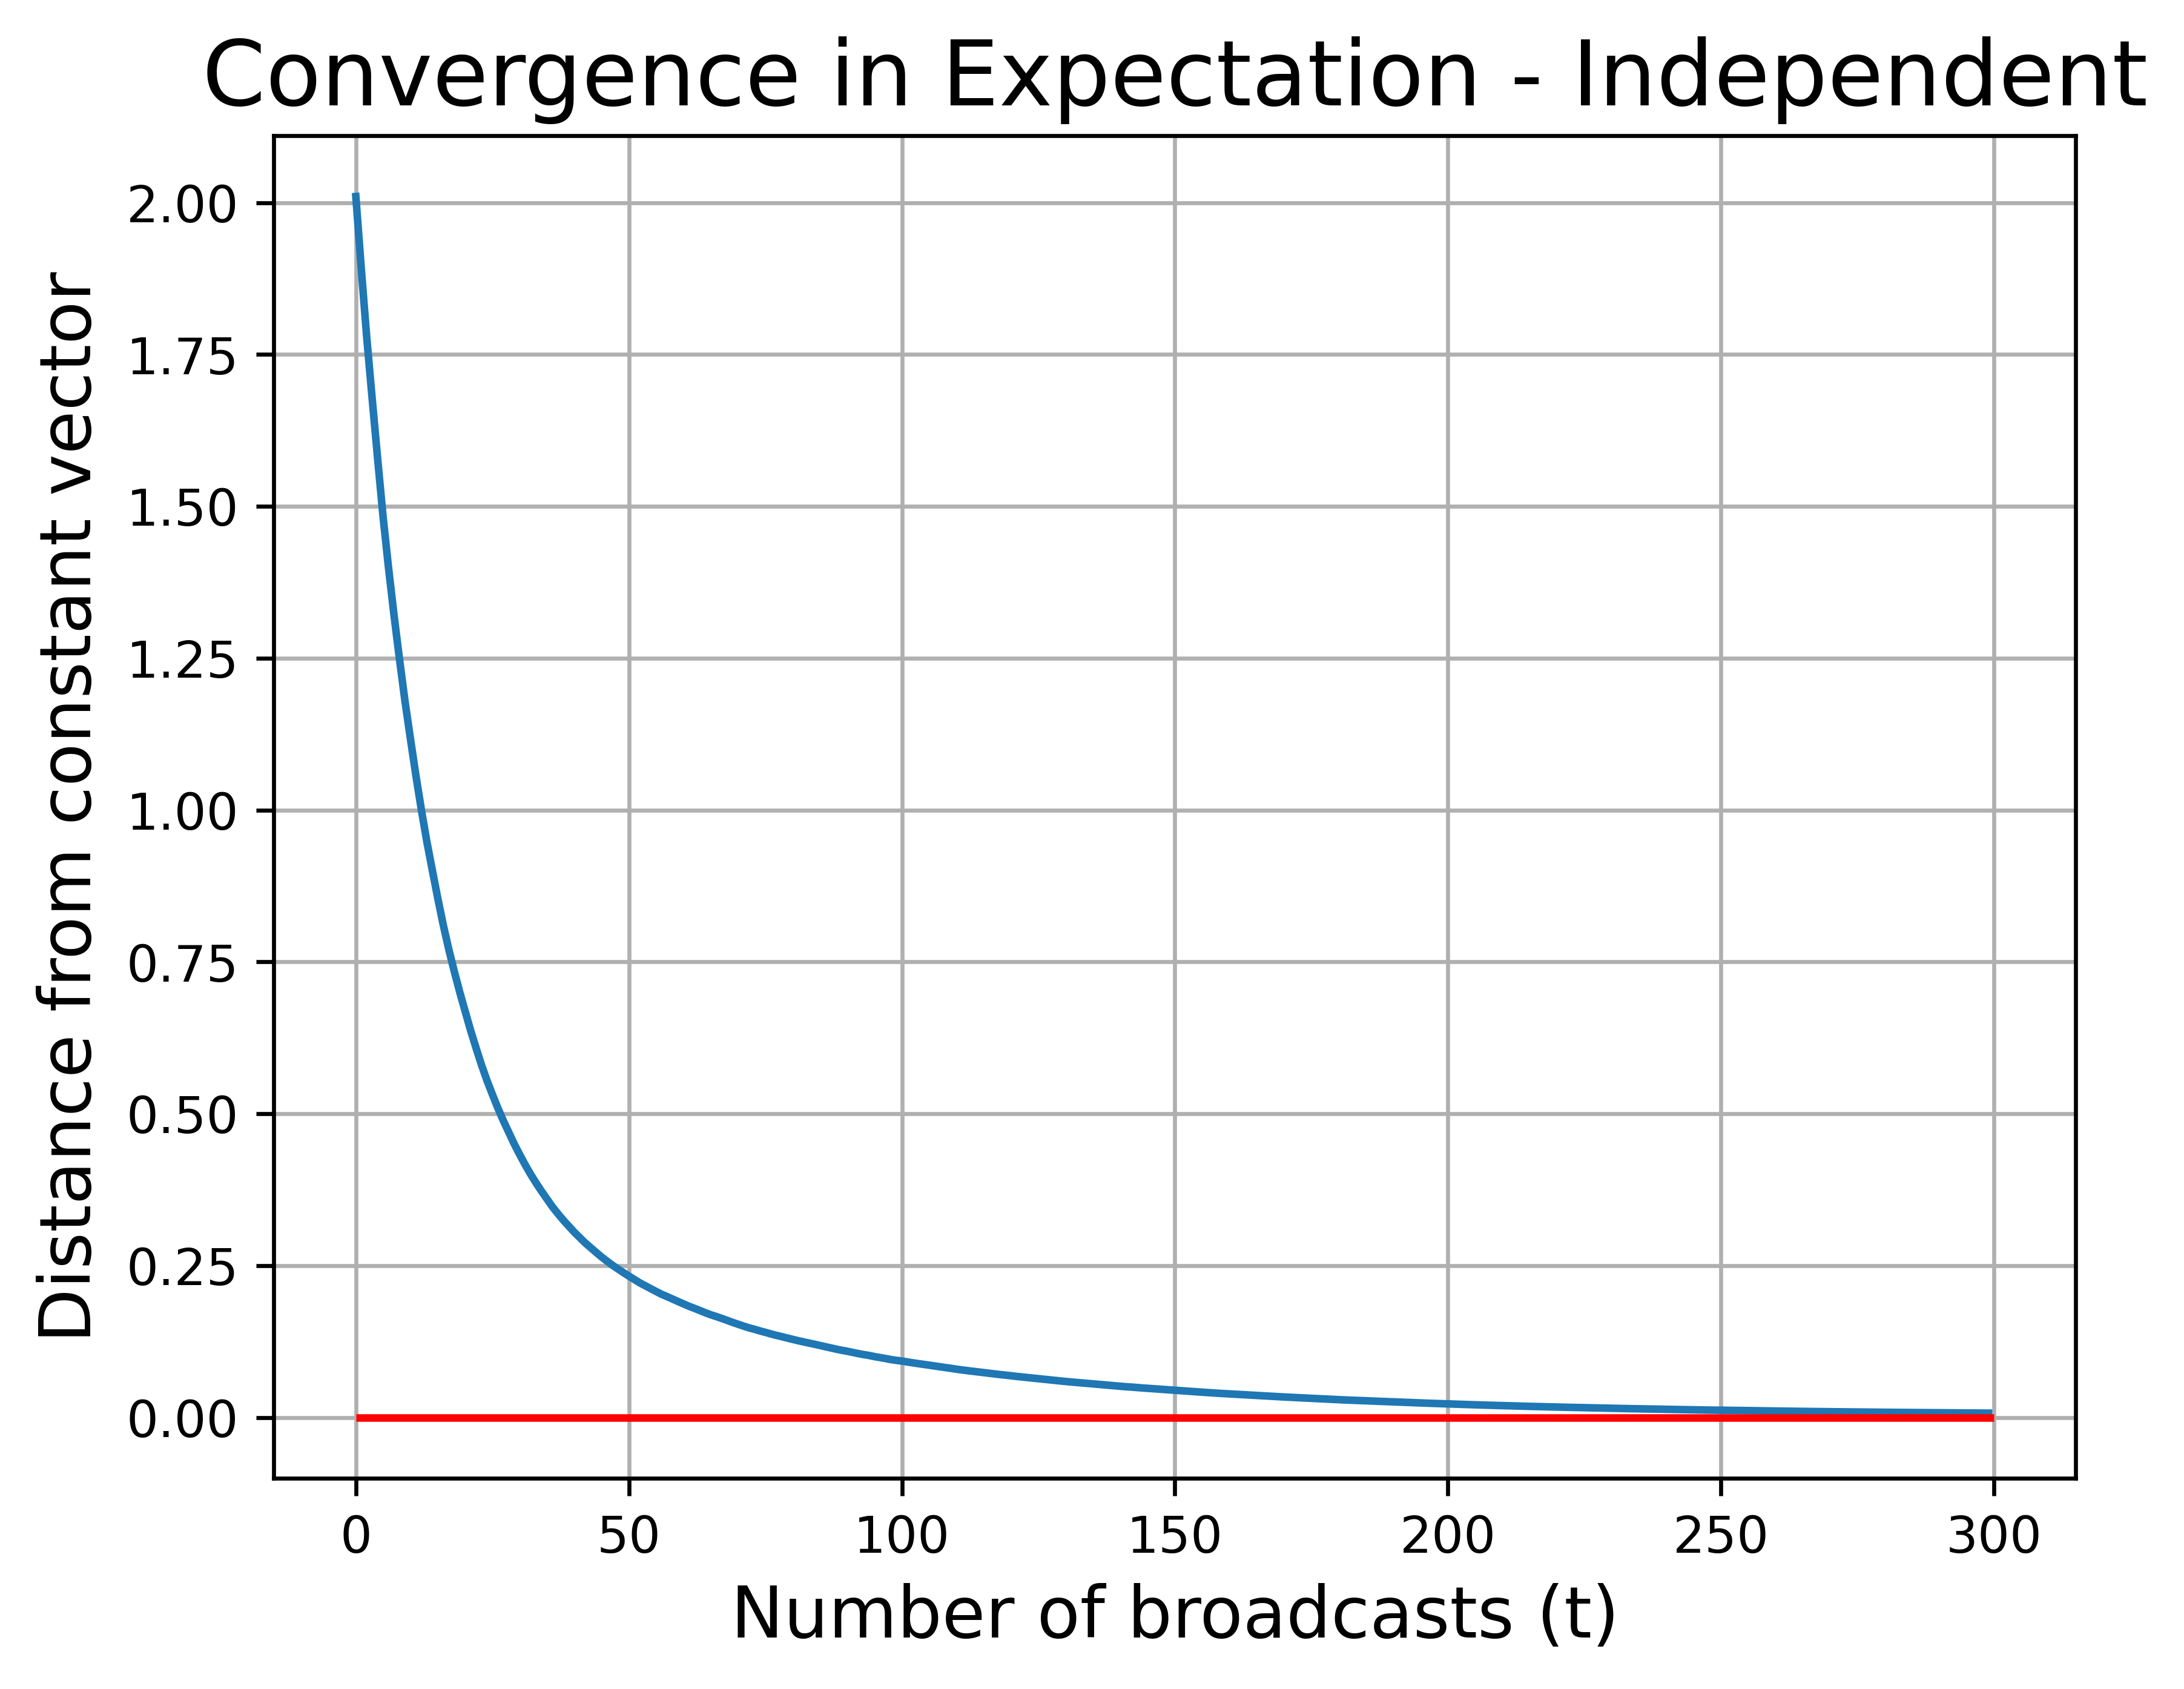

In [93]:
# Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_indep_1[0:300])
ax.hlines(0, 0, 300, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation - Independent", fontsize=18)
fig.set_dpi(600)

In [ ]:
#Convergence in second moment data generation

t = time

x_0 = np.random.random(N)
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
t_array = np.array([_ for _ in range(t+1)])
beta_arr = np.zeros((t+1, N), dtype=np.float64)

for _ in range(sim_num):
    output = indep_stoch_sim(x_0, adj_mat, gam, t)
    for i in range(t+1):
        beta_arr[i] += beta_matrix@output[i]

plot_vals_indep_2 = np.linalg.norm(beta_arr, axis=1)
plot_vals_indep_2 /= sim_num

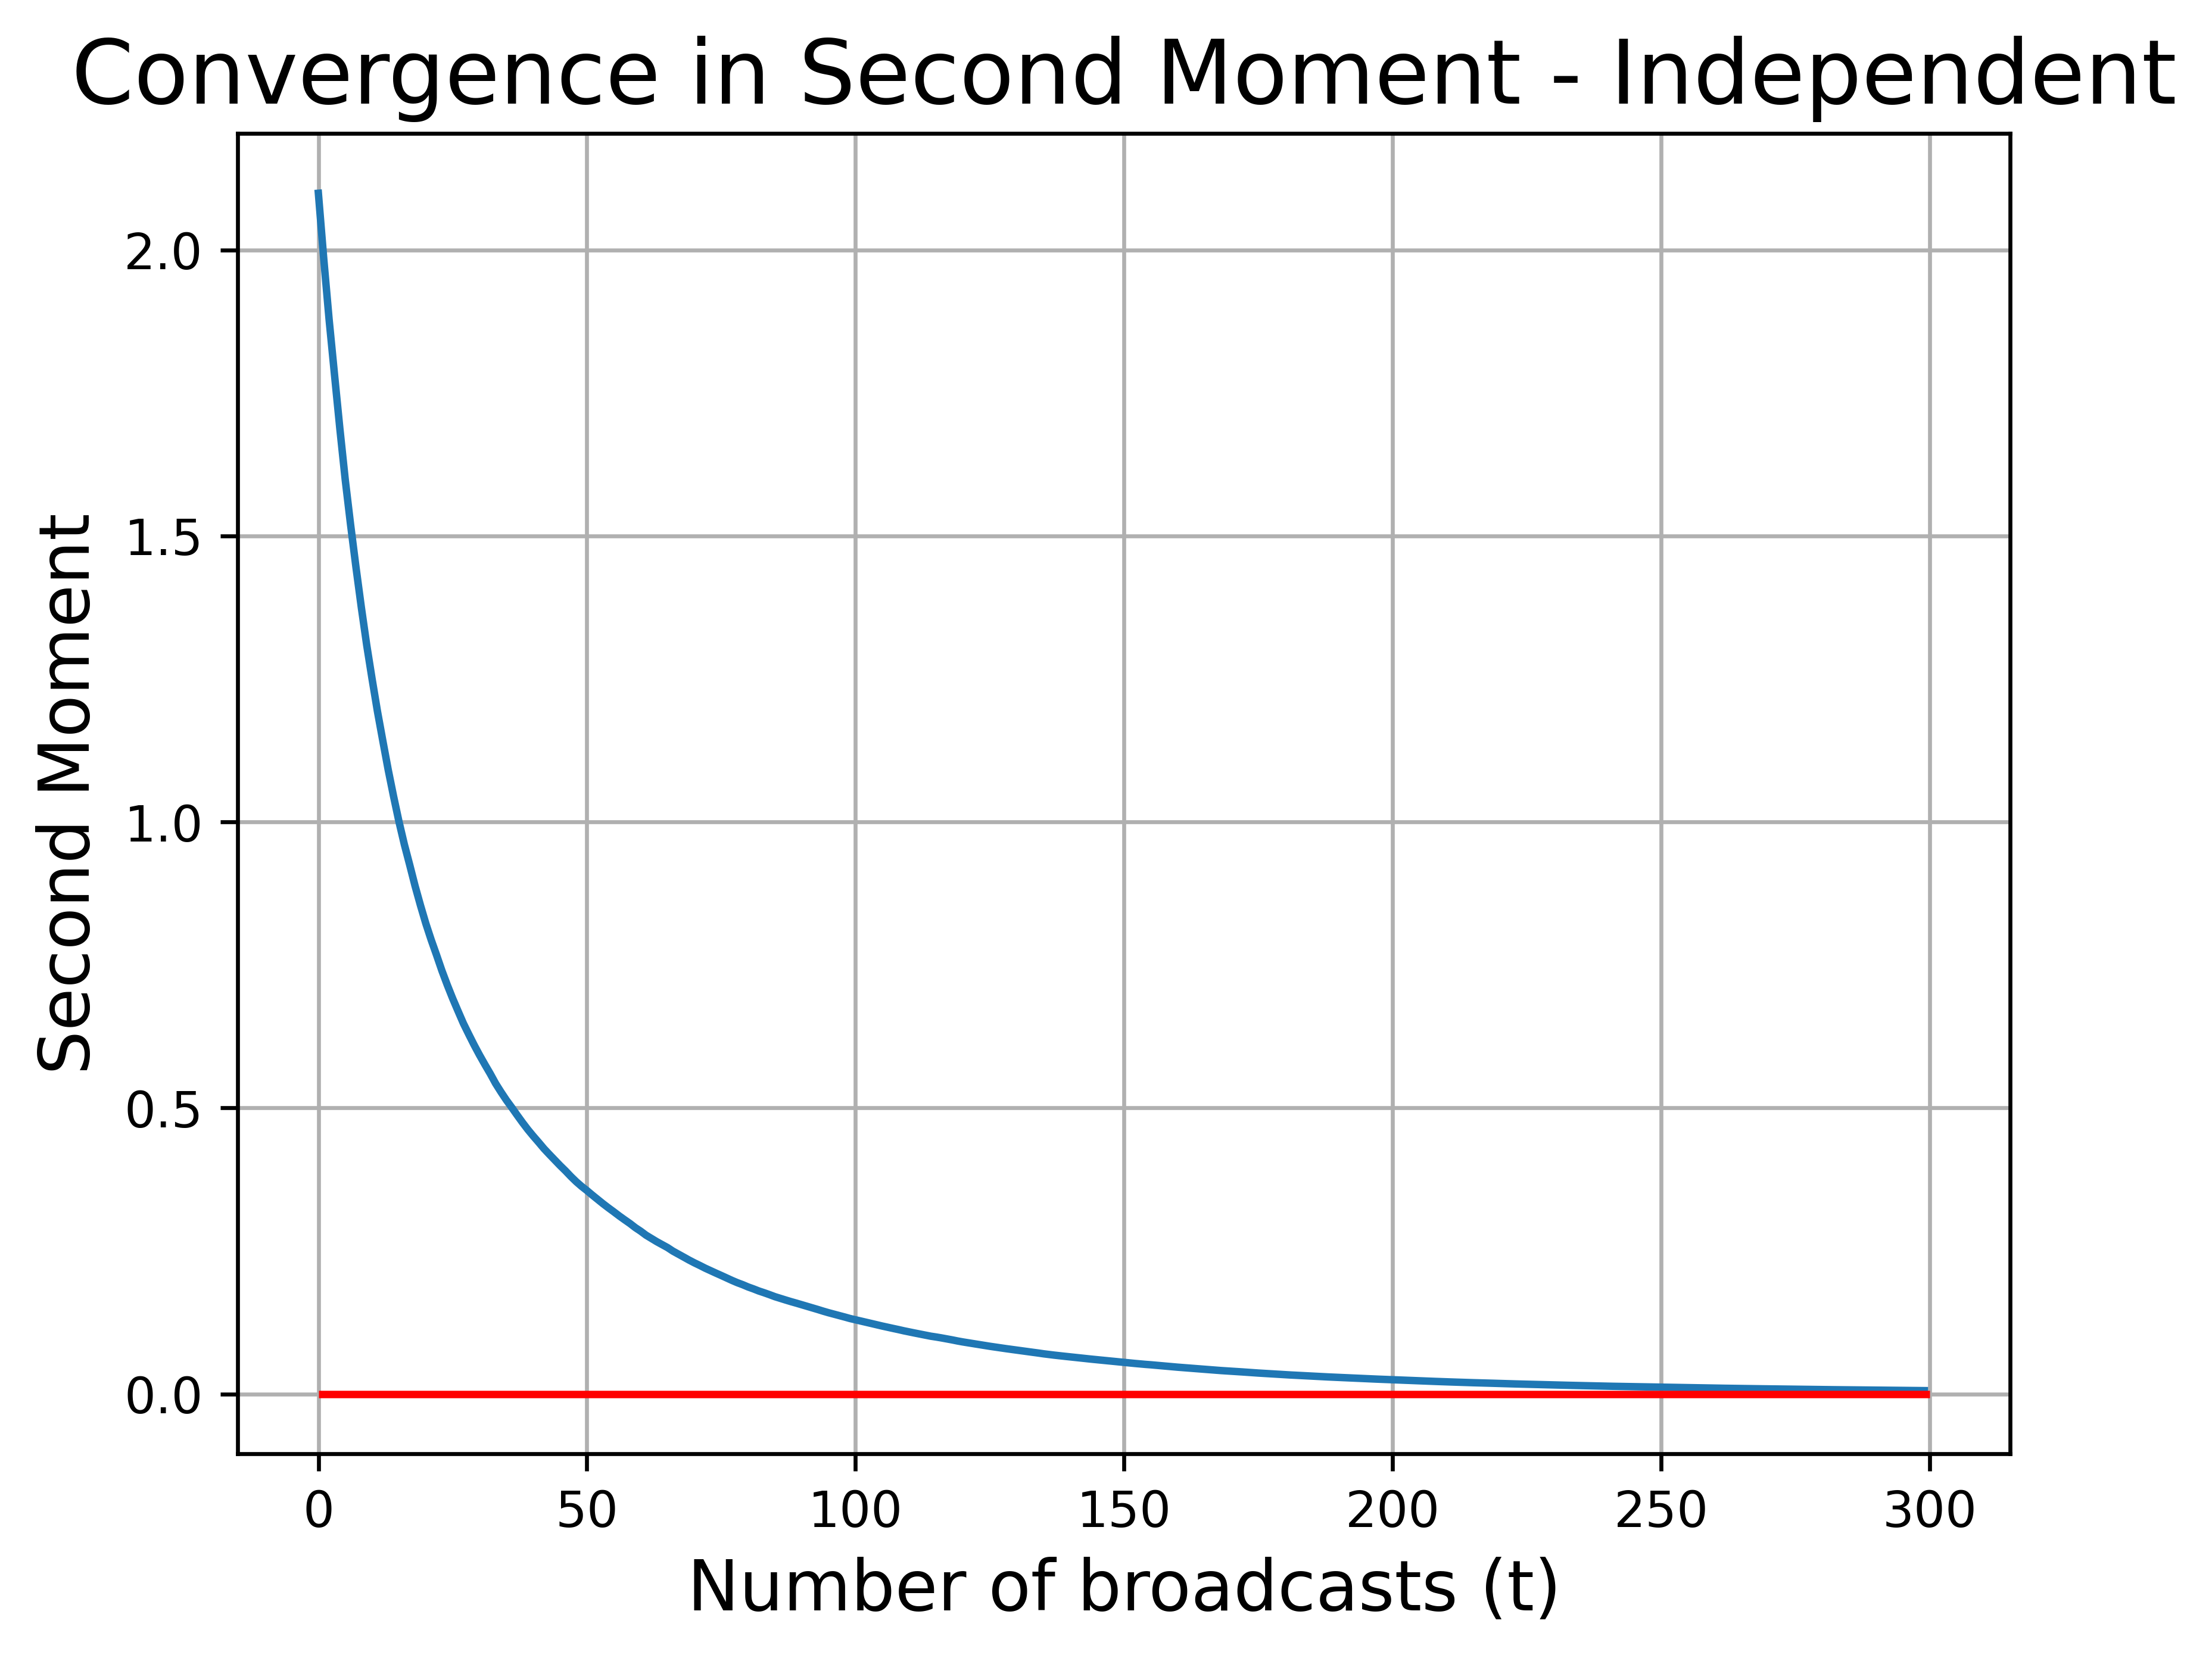

In [96]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_indep_2[0:300])
ax.hlines(0, 0, 300, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment - Independent", fontsize=18)
fig.set_dpi(600)

## Generalisation to Dependent Stochastic Mixing Parameter

In [108]:
#A single step of the simulation

def dep_update_step(x, adj_mat, gam_dict):
    N = len(x)
    i = np.random.randint(N, size=1)
    gamma = np.random.uniform(0, gam_dict[i])
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

In [109]:
import numpy as np

def dep_stoch_sim(x_0, adj_mat, gam_dict, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(dep_update_step(x_list[-1], adj_mat, gam_dict))
    return np.array(x_list)

In [107]:
import networkx as nx

N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

G = nx.from_numpy_array(adj_mat)
gam_dict = nx.degree_centrality(G)

x_0 = np.random.random(N)

In [ ]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))

for _ in range(sim_num):
    x_array += dep_stoch_sim(x_0, adj_mat, gam_dict, time)

x_array /= sim_num
x_array -= desired_x

plot_vals_dep_1 = np.linalg.norm(x_array, axis=1)

## Communication Cost Study

In [98]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gam = 1
gamma = 0.5

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [101]:
#The following generates data for investigating communication cost

import numpy as np

k = 15

steps = np.arange(100, k*100+1, 100)
per_node_var_weighted = np.zeros(steps.shape, dtype=np.float64)
per_node_var_indep = np.zeros(steps.shape, dtype=np.float64)

x_0 = np.random.random(N)
J = 1/N * np.ones((N, N))

for _ in range(0, 100):
    for i in range(0, k):
        output = simulate(x_0, adj_mat, gamma, steps[i])[-1]
        per_node_var_weighted[i] += np.linalg.norm(output - J @ output) / N
        output_2 = indep_stoch_sim(x_0, adj_mat, gam, steps[i])[-1]
        per_node_var_indep[i] += np.linalg.norm(output_2 - J @ output_2) / N

per_node_var_weighted /= 100
per_node_var_indep /= 100

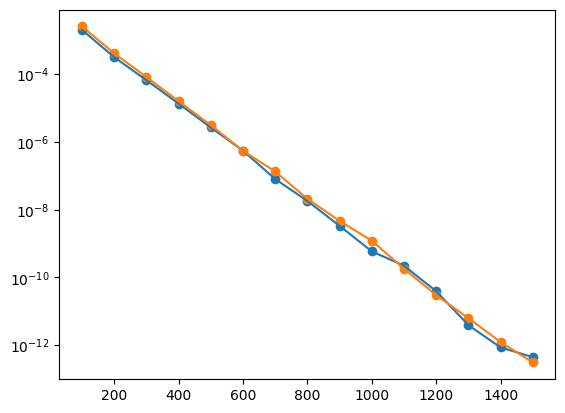

In [102]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.semilogy(steps, per_node_var_weighted)
ax.scatter(steps, per_node_var_weighted)

ax.semilogy(steps, per_node_var_indep)
ax.scatter(steps, per_node_var_indep)